# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
heart_df=pd.read_csv("heartDisease/framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

<AxesSubplot:ylabel='TenYearCHD'>

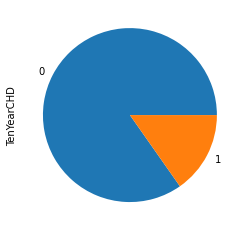

In [4]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [5]:
x = heart_df.values
scaler = MinMaxScaler()# Utilice un MinMaxScaler en esta ocasión #
x_scaled = scaler.fit_transform(x) # Aplique el escalamiento #
heart_df_scaled = pd.DataFrame(x_scaled, columns=heart_df.columns) # Conversión a un DataFrame #

In [6]:
x = heart_df_scaled.iloc[:,:-1]
y = heart_df_scaled.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [7]:
logreg = LogisticRegression() # Modelo de Regresión Logística #
logreg.fit(x_train,y_train) # Entrenamiento sobre los Datos #
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {accuracy_score(y_test,y_pred)}')

Precisión inicial: 0.8453333333333334


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

<AxesSubplot:>

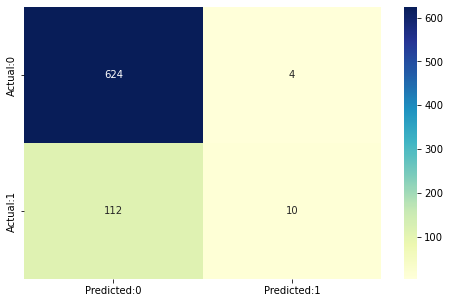

In [8]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [9]:
from sklearn.preprocessing import binarize

umbrales = np.arange(0,1,0.1) # Vector que Contiene los Umbrales a Analizar #

for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)[:,1] # Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred_prob_yes = y_pred_prob_yes.reshape(1,-1)
    y_pred2 = binarize(y_pred_prob_yes, threshold=umbral)[0] # Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test,y_pred2)
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos negativos.
Sensitividad: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n
Precisión: {accuracy_score(y_test,y_pred2)}\n''')


->Para un umbral de 0.0 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0

Precisión: 0.16266666666666665

->Para un umbral de 0.1 tenemos esta matriz de confusión:
[[296 332]
 [ 20 102]]
Con 398 predicciones correctas y 20 falsos negativos.
Sensitividad: 0.8361 Especificidad: 0.4713

Precisión: 0.5306666666666666

->Para un umbral de 0.2 tenemos esta matriz de confusión:
[[499 129]
 [ 55  67]]
Con 566 predicciones correctas y 55 falsos negativos.
Sensitividad: 0.5492 Especificidad: 0.7946

Precisión: 0.7546666666666667

->Para un umbral de 0.3 tenemos esta matriz de confusión:
[[582  46]
 [ 87  35]]
Con 617 predicciones correctas y 87 falsos negativos.
Sensitividad: 0.2869 Especificidad: 0.9268

Precisión: 0.8226666666666667

->Para un umbral de 0.4 tenemos esta matriz de confusión:
[[610  18]
 [104  18]]
Con 628 predicciones correctas y 104 falsos negativos.
Sensitividad: 0.1475 Especific

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

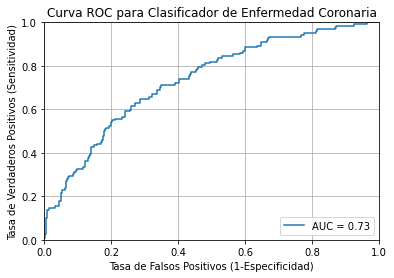

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes.reshape(-1,1))
auc = roc_auc_score(y_test, y_pred_prob_yes.reshape(-1,1))
plt.plot(fpr,tpr, label='AUC = %0.2f' % auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.legend(loc="lower right")
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [11]:
np.random.seed(22)
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #

w = w0.copy()
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-2
error = 100
dif = 100
errores = [] # En esta lista se agregan los valores de la función de error en cada iteración #


def sigma(w,x):
    res_sigmoid = 1 / (1 + np.exp(-(np.dot(w,x)))) # Salida de la función sigmoide #
    return res_sigmoid

tasas = [0.1] # Defina un vector que contenga las tasas que desea probar #
for tasa in tasas:
    w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #
    w = w0.copy()
    error = 100
    errores = [] # En esta lista se agregan los valores de la función de error en cada iteración #

    while abs(error)>eps:         # Criterio de parada 1 #
    #for j in range (0, 1000):  # Criterio de parada 2 #
        # # Desarrollo de algoritmo # #
        # Selección de par aleatorio
        i = np.random.randint(len(y_train_array))
        xActual = X_train_array[i]
        yActual = y_train_array[i]
        
        g = sigma(w,xActual) # Predicción del modelo
        
        error = yActual-g     #Cálculo del error
        
        w = w + (tasa*error*xActual) #Cálculo del modelo w
        
        errores.append(abs(error)) # Norma del gradiente a la lista de errores #
        # # # # # # # # # # # # # # # #
        
    X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
    y_test_array = y_test.values

    y_pred = np.zeros(len(x_test))
    y_pred_prob=[]
    for i in range(0,len(x_test)):
        prob = sigma(w,X_test_array[i])
        y_pred_prob.append(prob)
        if prob>0.2:
          y_pred[i] = 1
        else:
          y_pred[i] = 0

    print(f'Para una tasa de: {tasa}, la precisión de modelo actual es: {round(sklearn.metrics.accuracy_score(y_test,y_pred),4)}\nEl número de errores calculados fue: {len(errores)} \n')

Para una tasa de: 0.1, la precisión de modelo actual es: 0.8067
El número de errores calculados fue: 22673 



## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

Con 605 predicciones correctas y 76 falsos negativos.
Sensitividad: 0.377 Especificidad: 0.8901

Precisión: 0.8373333333333334



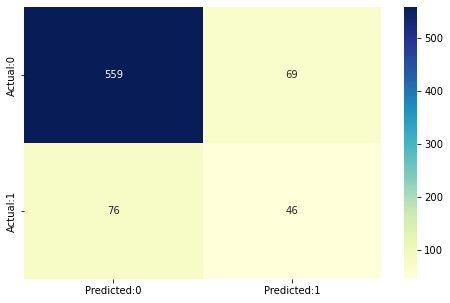

In [14]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(f'''Con {cm[0,0]+cm[1,1]} predicciones correctas y {cm[1,0]} falsos negativos.
Sensitividad: {round(cm[1,1]/(float(cm[1,1]+cm[1,0])), 4)} Especificidad: {round(cm[0,0]/(float(cm[0,0]+cm[0,1])), 4)}\n
Precisión: {accuracy_score(y_test,y_pred2)}\n''')

0.7382661585047509

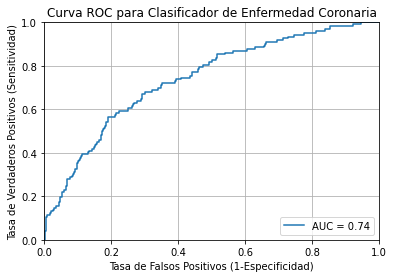

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr, label='AUC = %0.2f' % auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.legend(loc="lower right")
plt.grid(True)
auc

## Conclusiones

De los resultados obtenidos en la parte 1 se concluye:
- La sensitividad o tasa de verdaderos positivos (TPR en inglés) y la especificidad o tasa de verdaderos negativos (TNR en inglés) son inversamente proporcional y pueden varíar respecto al valor umbral definido.

- Si se desea aumentar la sensitividad o el TPR se debe disminuir el valor del umbral teniendo presente que al mismo tiempo aumenta la tasa de falsos positivos (FPR en inglés). En el caso de la predicción de padecer enfermedad coronaria 10 años en el futuro, consideramos que se debe aumentar la sensitividad para predecir correctamente el mayor número de pacientes que padecen la enfermedad así aumente el número de falsos positivos, consideramos un umbral de 0.2 como adecuado porque aumenta la sensitividad a 0.55 y mantiene una precisión de 0.75.

- La métrica AUC obtenida en el modelo de regresión logística fue de 0,73, lo que indica que hay una probabilidad del 73% que el modelo sea capaz de distinguir entre padecer o no padecer enfermedad coronaria a 10 años en el futuro. Es un buen resultado teniendo en cuenta que es cercano a uno lo que indica una buena medida de separabilidad de los datos.

De los resultados obtenidos en la parte 2 se concluye:

- En el algoritmo de ascenso de gradiente estocástico se probaron tasas de aprendizaje de 1, 0.5, 0.1 y 0.05 con un umbral de 0.2. Se obtuvieron modelos de buena precisión (aprox. 0,84) con pocas iteraciones (alrededor de 100) para tasas de 1 y 0.5. Sin embargo, se comprobó que a pesar de la precisión en estas tasas, el modelo no es "bueno" porque la tasa de verdaderos positivos es 0.0, es decir, el modelo no predijo correctamente persona alguna con la enfermedad coronaria lo cuál resulta muy grave.

- De las tasas de aprendizaje probadas la de 0.1 fue la que obtuvo el mejor modelo con una tasa de verdaderos positivos de 0.377, una precisión de 0.837 y un AUC de 0.74. En este caso se predijeron correctamente 46 pacientes de 122 positivos.